In [6]:
#Import Data from github repo
#Link to water ministry website [https://www.maji.go.tz/]
#Link to dataset by  [https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/]

#Importing the python library 
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np
from IPython.display import Image
from pylab import rcParams
import geopandas
import datetime

#Fetch files from github repo to protect accidental changes in data and protect data integrity 
features = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_features.csv'
target = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_labels.csv'
test = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/test_features.csv'


#creating the panda dataframes
#Features are the dataframe containing the input variables for the model
features = pd.read_csv(features)
#Labels are the predction variables
labels = pd.read_csv(target)
#X_test is the test variables  
X_test = pd.read_csv(test)

#meging features and laebles to create single data frame based on index
df = features.merge(labels, on = features.index)

print("prediction variable \n",labels.columns)
print('\n')
print("feature variable \n",features.columns)



prediction variable 
 Index(['id', 'status_group'], dtype='object')


feature variable 
 Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


In [7]:
# Data Cleaning - filling out the missing values and zero values in the dataset 
# find out the missing values in the dataset
print(features.isna().sum())

# calculating the non zero mean of the distribution 
print("\nNon zero mean for the construction_year - " ,features['construction_year'][ features['construction_year'] != 0 ].mean() )
# replacing the zero vales for the construction year with non zero mean ie 1995
features['construction_year'] = features['construction_year'].replace({0:1996})


id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [8]:
#Feature Engineering 
# Feature engineering - calculating age of the pump 
features['age'] = features['date_recorded'].astype(str).str[:4].astype(int) - features['construction_year']
print("\nMean of the age of pump - ",features['age'].mean())

# Feature engineering - calculating the population served per year
features['pop/year'] = features['population'].replace({0:1}) / features['age'].replace({0:1})
print("\nMean of pop/year - ",features['pop/year'].mean())

# Feature engineering - calculating the water each person gets from water pump 
features['water_/_person'] = features['amount_tsh'].replace({0:1}) / features['population'].replace({0:1}) 
print("\nMean of water_/_person - ",features['water_/_person'].mean())

# Modifying the data for test dataset accordingly 
X_test['construction_year'] = X_test['construction_year'].replace({0:1993})
X_test['age'] = X_test['date_recorded'].astype(str).str[:4].astype(int) - X_test['construction_year']
X_test['pop/year'] = X_test['population'].replace({0:1}) / X_test['age'].replace({0:1})
X_test['water_/_person'] = X_test['amount_tsh'].replace({0:1}) / X_test['population'].replace({0:1})


Mean of the age of pump -  15.391010101010101

Mean of pop/year -  36.174045641256434

Mean of water_/_person -  70.35625816674902


In [9]:
# Encoding the features in the data for building data piplelines model using sklearn
# References [https://heartbeat.fritz.ai/a-practical-guide-to-feature-engineering-in-python-8326e40747c8]
#   Using oneHotEncoding for low cardinality feature 
#   Using ordinal Encoding for High cardinality feature
#   Logic [if cardinality > 150 -> High cardinality else Low cardinality] 

# Function to check the cardinality [unique values] of the feature variables
def reverse_cardinality_check(n, df):
  feature_list = []
  cardinality_value = []

  for _ in range(len(df.columns)):
    if len(df[df.columns[_]].value_counts()) > n:
      feature_list.append(df.columns[_])
      cardinality_value.append(len(df[df.columns[_]].value_counts()))

  feature_dict = dict(zip(feature_list, cardinality_value))

  return feature_dict

# creating data frames for high cardinality and low cardinality features for encoding 
# Bifuracting high cardinality features and [checking columns more than 150 unique values  ]
high_cardinality_feature_dict = reverse_cardinality_check(150, features)
high_cardinality_features = features[list(high_cardinality_feature_dict.keys())]
high_cardinality_features.columns
print("\n High Cardinality features -\n ",high_cardinality_feature_dict)

# Bifurcating low cardinality features
low_cardinality_features = features.drop(columns = list(high_cardinality_feature_dict.keys()))
print("\n Low Cardinality features -\n ",low_cardinality_features.columns)

#Encoding the low and high cardinality features 
one_hot_encode = ce.OneHotEncoder(use_cat_names=True)
one_hot_encode.fit(low_cardinality_features, labels['status_group'])
low_cardinality_features = one_hot_encode.transform(low_cardinality_features)

ordinal_encode = ce.OrdinalEncoder()
ordinal_encode.fit(high_cardinality_features, labels['status_group'])
high_cardinality_features = ordinal_encode.transform(high_cardinality_features)


# Merging both cardinality back into feature dataset
features = low_cardinality_features.merge(high_cardinality_features,on = low_cardinality_features.index)

feature_names = features.columns
print("\n features columns -\n ",feature_names)


 High Cardinality features -
  {'id': 59400, 'date_recorded': 356, 'funder': 1897, 'gps_height': 2428, 'installer': 2145, 'longitude': 57516, 'latitude': 57517, 'wpt_name': 37400, 'subvillage': 19287, 'ward': 2092, 'population': 1049, 'scheme_name': 2696, 'pop/year': 4465, 'water_/_person': 2633}

 Low Cardinality features -
  Index(['amount_tsh', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'age'],
      dtype='object')
C:\Users\dhava\anaconda3\envs\poseidon\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will

In [10]:
# Imputing [imputation is replacing missing data with substituted values in my case it is mean ]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(features, labels['status_group'])
features = imputer.transform(features)


In [11]:
# Scaling the features [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html]
scaler = RobustScaler()
scaler.fit(features, labels['status_group'])
features = scaler.transform(features)

In [12]:
# Performing the encoding, Imputing and scaling for the test dataset
high_cardinality_X_test_dict = reverse_cardinality_check(150, X_test)
high_cardinality_X_test_dict

low_cardinality_X_test = X_test.drop(columns = list(high_cardinality_X_test_dict.keys()))
low_cardinality_X_test.columns

high_cardinality_X_test = X_test[list(high_cardinality_X_test_dict.keys())]
high_cardinality_X_test.columns

low_cardinality_X_test = one_hot_encode.transform(low_cardinality_X_test)

high_cardinality_X_test = ordinal_encode.transform(high_cardinality_X_test)

X_test = low_cardinality_X_test.merge(high_cardinality_X_test,on = low_cardinality_X_test.index)

X_test = imputer.transform(X_test)



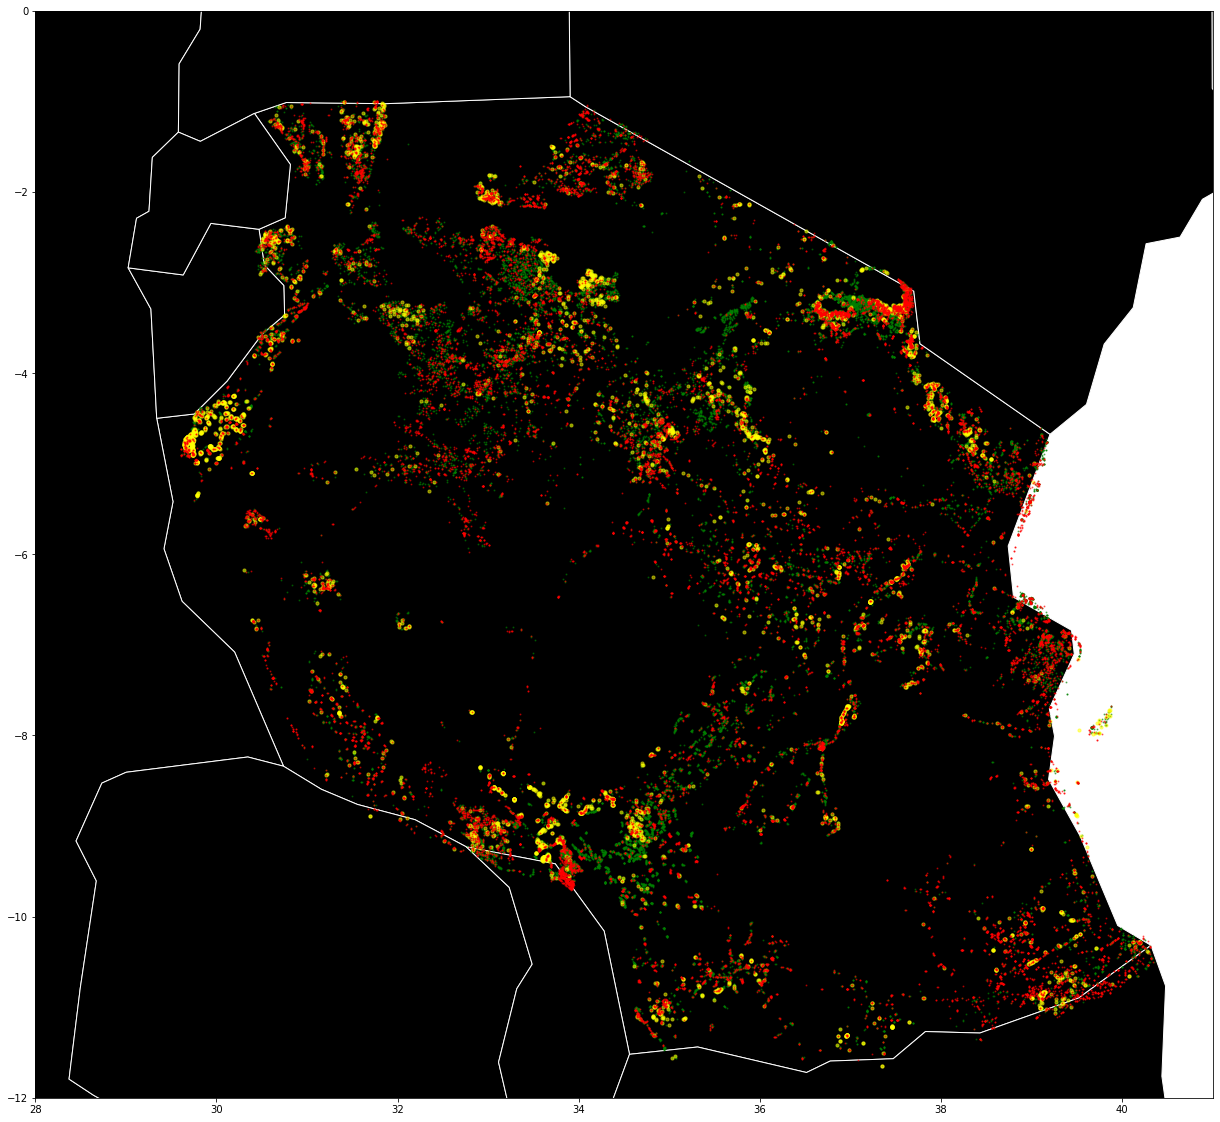

In [13]:
#Ploting the map based on longitude and latitude using geopandas library 
# [Reference https://blog.cambridgespark.com/managing-spatial-data-using-geopandas-in-python-8e70c646f708]
# Red - non functional
# green - functional
# Yellow - functional but need service 

rcParams['figure.figsize'] = 30, 20

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
#dividing gdf into 3 sections 
functional = gdf.where(gdf['status_group'] == 'functional')
repair = gdf.where(gdf['status_group'] == 'functional needs repair')
broken = gdf.where(gdf['status_group'] == 'non functional')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#Ploting the base plot of the map of Tanzania 
ax = world[world.continent == 'Africa'].plot(color='black', edgecolor='white')

ax.scatter(functional['longitude'], functional['latitude'],c='green',alpha=.5, s=1)
ax.scatter(repair['longitude'], repair['latitude'],c='yellow', alpha=.5, s=10)
ax.scatter(broken['longitude'], broken['latitude'],c='red', alpha=.5, s=1)

# For adjusting the base plot map 
plt.ylim(-12, 0)
plt.xlim(28,41)

plt.show()


In [14]:
# CREATING THE MODEL USING RANDOM FOREST CLASSIFIER
# Refrence[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html] 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#Traing the random classifier model
#x_Matrix represents the input variables as input variable for the model
#Y_Matrix represents the prediction variable as output varible for the model
X_matrix, y_vector = features, labels['status_group']
param_distributions = {
    'max_depth': [25, 26, 27, 28, 29]
}

#Building the random forest archietecture (gridsearch) with parameters 
gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=92, n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_matrix, y_vector)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:  1.0min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.9min remaining:   53.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  1.9min remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  1.9min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=92, n_jobs=-1,
                                                    random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [25, 26, 27, 28, 29]},
                   return_train_score=True, scoring='accuracy', verbose=10)

Best result from search of 5 parameter combinations
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      43.554276      4.584293         6.673383        4.270929   
1      47.552814      4.141016         3.641406        3.548499   
2      42.083024      6.088235         6.598781        4.256479   
3      43.398201      1.953617         3.498282        2.190667   
4      37.250621     15.090270         1.662129        0.757253   

  param_max_depth             params  split0_test_score  split1_test_score  \
0              25  {'max_depth': 25}           0.812121           0.806566   
1              26  {'max_depth': 26}           0.812374           0.810185   
2              27  {'max_depth': 27}           0.814983           0.809680   
3              28  {'max_depth': 28}           0.813721           0.809175   
4              29  {'max_depth': 29}           0.816414           0.809596   

   split2_test_score  split3_test_score  ...  mean_test_score  std_test_scor

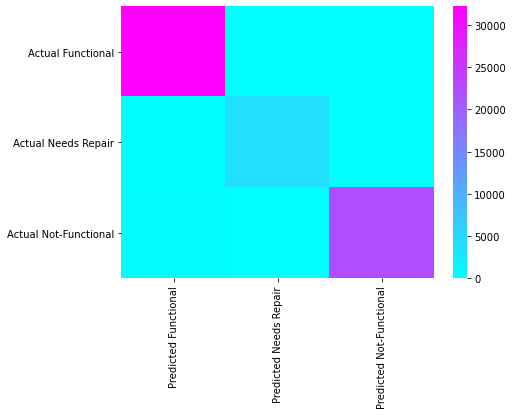

Predicted Functional  Predicted Needs Repair  \
Actual Functional                     32249                       0   
Actual Needs Repair                     194                    4116   
Actual Not-Functional                   329                       0   

                       Predicted Not-Functional  
Actual Functional                            10  
Actual Needs Repair                           7  
Actual Not-Functional                     22495

In [15]:
#Print model training statastics to determine how well model performed in training 
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(5)
model = gridsearch.best_estimator_
print(results)

#Confusion matrix analysis code to check for missclassification rate for the trained model
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

rcParams['figure.figsize'] = 7, 5
def con_matrix_analysis(model):
  x = model.predict(features)
  y = y_vector
  
  print(classification_report(y, x,
        target_names=['Functional', 'Needs Repair', 'Not-Functional']))

  con_matrix = pd.DataFrame(confusion_matrix(y, x), 
             columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Not-Functional'], 
             index=['Actual Functional', 'Actual Needs Repair', 'Actual Not-Functional'])
                            
  sns.heatmap(data=con_matrix, cmap='cool')
  plt.show();
  return con_matrix

con_matrix_analysis(model)

In [16]:
#--------------------------------------------------------------------------------------------------------------------------------
# Work in progress to find important features 
#--------------------------------------------------------------------------------------------------------------------------------
# features in the model and finding its importance in predicting the water pump status 

features_importance = model.feature_importances_
 
print("Feature ranking:")
for i, data_class in enumerate(features_importance):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))


Feature ranking:
1. 0.03463192526469916 (0.03463192526469916)
2. 0.012333527382528525 (0.012333527382528525)
3. 0.0007160263292597667 (0.0007160263292597667)
4. 0.002094194629004566 (0.002094194629004566)
5. 0.0021546400064808295 (0.0021546400064808295)
6. 0.0017245175469428893 (0.0017245175469428893)
7. 0.0015471449521848762 (0.0015471449521848762)
8. 0.00263771452312041 (0.00263771452312041)
9. 0.0021587359501802354 (0.0021587359501802354)
10. 0.0018193699251775428 (0.0018193699251775428)
11. 0.001783635556980482 (0.001783635556980482)
12. 0.0018326182593071765 (0.0018326182593071765)
13. 0.002920501658697925 (0.002920501658697925)
14. 0.001063041288030069 (0.001063041288030069)
15. 0.0007355084788493594 (0.0007355084788493594)
16. 0.000644020499947095 (0.000644020499947095)
17. 0.0009441421141643932 (0.0009441421141643932)
18. 0.0011513660821714804 (0.0011513660821714804)
19. 0.001613734026104361 (0.001613734026104361)
20. 0.0006893466052223159 (0.0006893466052223159)
21. 0.00106213

In [17]:
#Pickle the model for the django deployment
#In pickleing the model we do not have to train the model again it is simply a way to save a model
pd.to_pickle(model,r'Random_forest_Water_Pump_prediction.pickle')

In [18]:
#--------------------------------------------------------------------------------------------------------------------------------
# Work in progress input and predict [prerocessing the user input]
#--------------------------------------------------------------------------------------------------------------------------------
import datetime

#test the model
Var_id = float(input("Enter id: "))
Var_amount_tsh = float(input("Enter amount_tsh: "))
#input date
Var_date_recorded = input("Enter date in YYYY-MM-DD format")
year, month, day = map(int, Var_date_recorded.split('-'))
Var_date_recorded = datetime.date(year, month, day)

Var_funder = input("Enter Funder: ")
Var_gps_height = int(input("Enter gps_height: "))
Var_installer = input("Enter installer: ")
Var_longitude = float(input("Enter longitude: "))
Var_latitude = float(input("Enter latitude: "))
Var_wpt_name = input("Enter wpt_name: ")
Var_num_private = int(input("Enter num_private: "))
Var_basin = input("Enter basin: ")
Var_subvillage = input("Enter subvillage: ")
Var_region = input("Enter region: ")
Var_region_code = int(input("Enter region_code: "))
Var_district_code = int(input("Enter district_code: "))
Var_lga = input("Enter lga: ")
Var_ward = input("Enter ward: ")
Var_population = int(input("Enter population: "))
Var_public_meeting = bool(input("Enter public_meeting true/false: "))
Var_recorded_by = input("Enter recorded_by: ")
Var_scheme_management = input("Enter scheme_management: ")
Var_scheme_name = input("Enter scheme_name: ")
Var_permit = bool(input("Enter permit true/false: "))
Var_construction_year = int(input("Enter construction_year: "))
Var_extraction_type = input("Enter extraction_type: ")
Var_extraction_type_group = input("Enter extraction_type_group: ")
Var_extraction_type_class = input("Enter extraction_type_class: ")
Var_management = input("Enter management: ")
Var_management_group = input("Enter management_group: ")
Var_payment = input("Enter payment: ")
Var_water_quality = input("Enter water_quality: ")
Var_quality_group = input("Enter quality_group: ")
Var_quantity = input("Enter quantity: ")
Var_quantity_group = input("Enter quantity_group: ")
Var_source = input("Enter source: ")
Var_source_type = input("Enter source_type: ")
Var_source_class = input("Enter source_class: ")
Var_waterpoint_type = input("Enter waterpoint_type: ")
Var_waterpoint_type_group = input("Enter waterpoint_type_group: ")

feed = [Var_id,Var_amount_tsh,Var_date_recorded,Var_funder,Var_gps_height,Var_installer,Var_longitude,Var_latitude,Var_wpt_name,Var_num_private,Var_basin,Var_subvillage,Var_region,Var_region_code,Var_district_code,Var_lga,Var_ward,Var_population,Var_public_meeting,Var_recorded_by,Var_scheme_management,Var_scheme_name,Var_permit,Var_construction_year,Var_extraction_type,Var_extraction_type_group,Var_extraction_type_class,Var_management,Var_management_group,Var_payment,Var_water_quality,Var_quality_group,Var_quantity,Var_quantity_group,Var_source,Var_source_type,Var_source_class,Var_waterpoint_type,Var_waterpoint_type_group]

#transformation with input data 
high_cardinality_feed = reverse_cardinality_check(150, feed)
high_cardinality_feed_dict

low_cardinality_feed = feed.drop(columns = list(high_cardinality_feed_dict.keys()))
low_cardinality_feed.columns

high_cardinality_feed = X_test[list(high_cardinality_X_test_dict.keys())]
high_cardinality_feed.columns

low_cardinality_feed = one_hot_encode.transform(low_cardinality_feed)

high_cardinality_feed = ordinal_encode.transform(high_cardinality_feed)

feed = low_cardinality_feed.merge(high_cardinality_feed,on = low_cardinality_feed.index)
feed = imputer.transform(feed)


result = model.predict([feed])
print(result) 

ValueError: could not convert string to float: ''

In [20]:
#Testing the model using test dataset
result = model.predict([X_test[2]])
print(result)

['non functional']
